Load Baseline Prompts and Nouns

In [5]:
!pip -q install transformers accelerate torch jsonlines --upgrade

import jsonlines, re, random
from google.colab import drive
from pathlib import Path

#mount drive
drive.mount('/content/drive')
NOTEBOOK_DIR = Path("/content/drive/MyDrive/Colab Notebooks")

# Define file paths
nouns_path = NOTEBOOK_DIR / "nouns.txt"
properties_path = NOTEBOOK_DIR / "properties.txt"

# Read contents
with open(nouns_path, "r") as f:
    nouns = f.read().splitlines()

with open(properties_path, "r") as f:
    properties = f.read().splitlines()

#Load baseline-prompts.jsonl
jsonl_path = NOTEBOOK_DIR / "baseline-prompts.jsonl"

with jsonlines.open(jsonl_path, "r") as reader:
    for obj in reader:
        print(obj)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'pre-prompt': 'Output Only 1-10. How heavy would you rate this noun: ', 'property': 'weight'}
{'pre-prompt': 'Output Only 1-10. How tall would you rate this noun: ', 'property': 'height'}
{'pre-prompt': 'Output Only 1-10. How agressive would you rate this noun: ', 'property': 'aggressiveness'}
{'pre-prompt': 'Output Only 1-10. How fast would you rate this noun: ', 'property': 'speed'}
{'pre-prompt': 'Output Only 1-10. How intelligent would you rate this noun: ', 'property': 'intelligence'}


Load Model and Evaluate Nouns

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'noun': 'Elephant', 'property': 'weight', 'prompt': 'Output Only 1-10. How heavy would you rate this noun: Elephant', 'response': '10', 'score': 10}
{'noun': 'Elephant', 'property': 'height', 'prompt': 'Output Only 1-10. How tall would you rate this noun: Elephant', 'response': '10', 'score': 10}
{'noun': 'Elephant', 'property': 'aggressiveness', 'prompt': 'Output Only 1-10. How agressive would you rate this noun: Elephant', 'response': '2', 'score': 2}
{'noun': 'Elephant', 'property': 'speed', 'prompt': 'Output Only 1-10. How fast would you rate this noun: Elephant', 'response': '7', 'score': 7}
{'noun': 'Elephant', 'property': 'intelligence', 'prompt': 'Output Only 1-10. How intelligent would you rate this noun: Elephant', 'response': '7', 'score': 7}
{'noun': 'Lion', 'property': 'weight', 'prompt': 'Output Only 1-10. How heavy would you rate this noun: Lion', 'response': '7', 'score': 7}
{'noun': 'Lion', 'property': 'height', 'prompt': 'Output Only 1-10. How tall would you rate thi

,noun,property,response


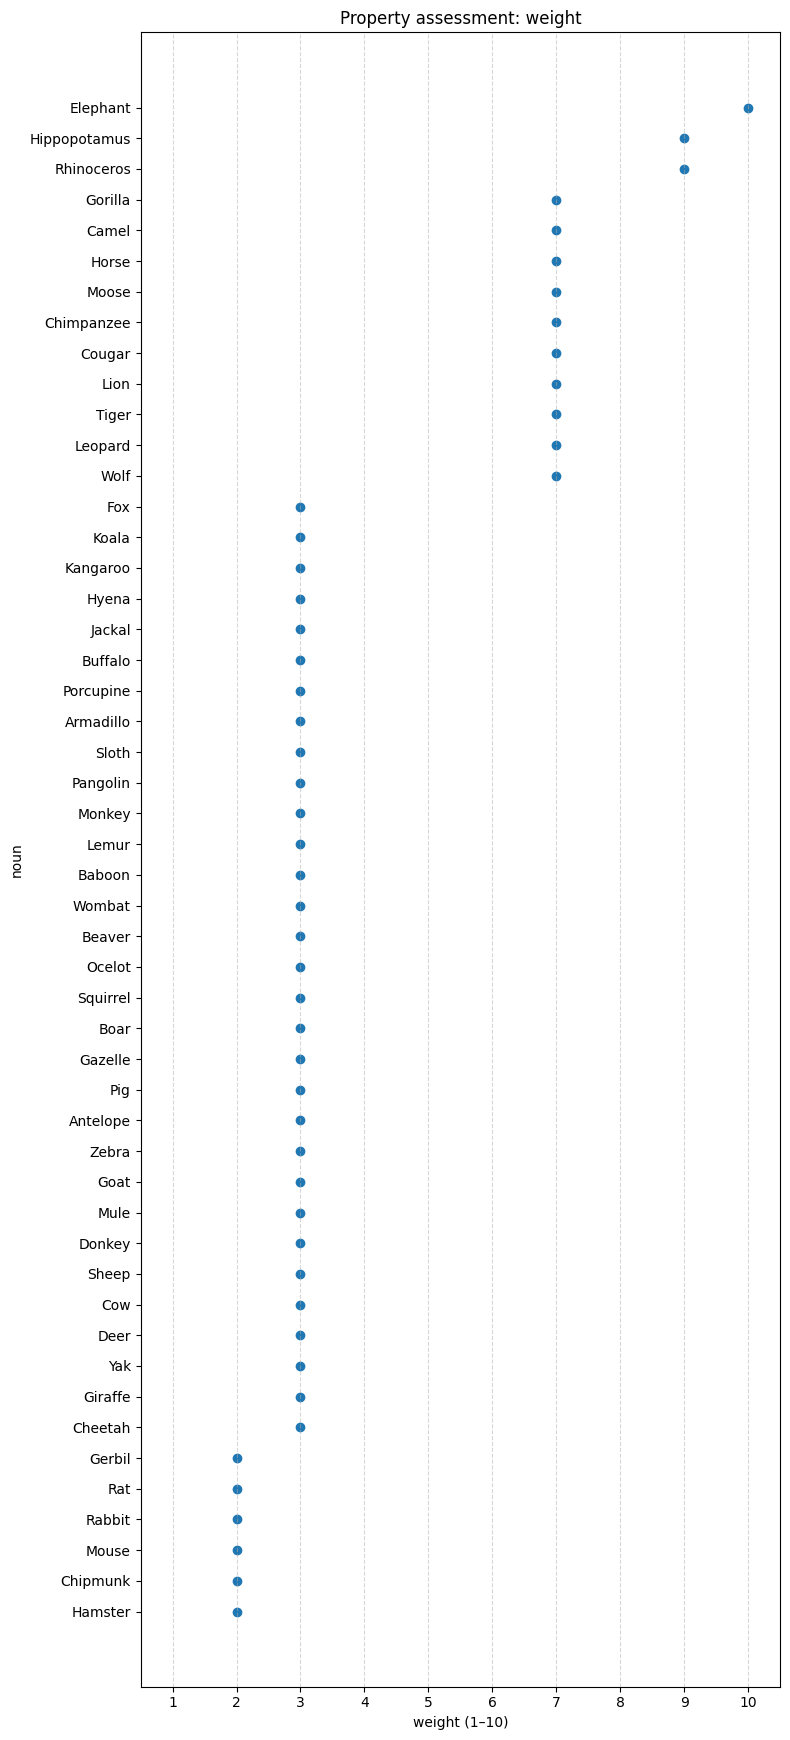

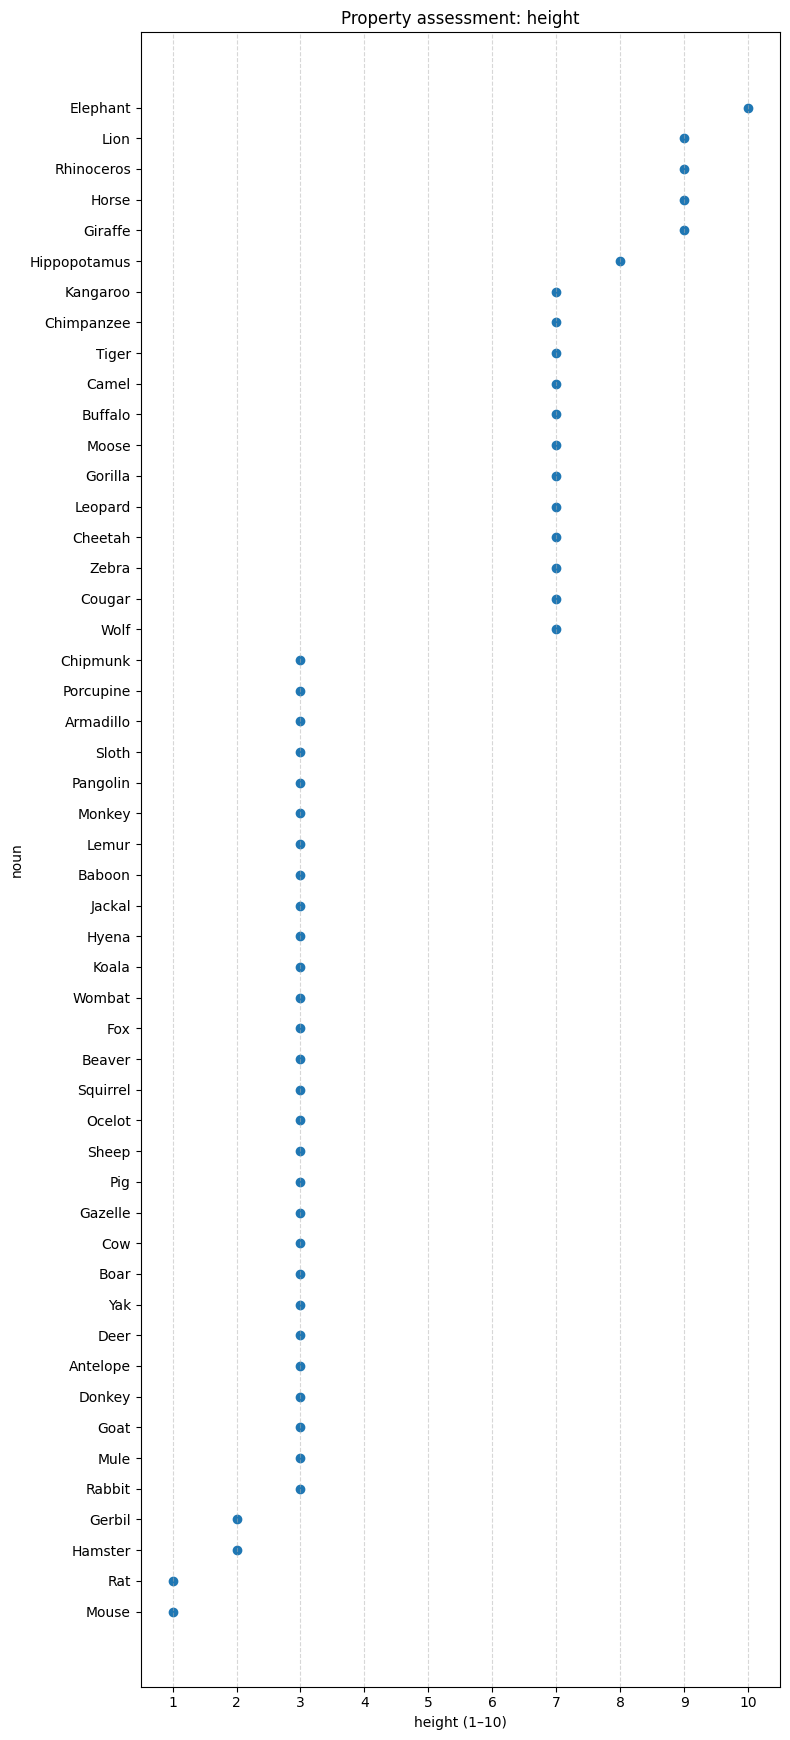

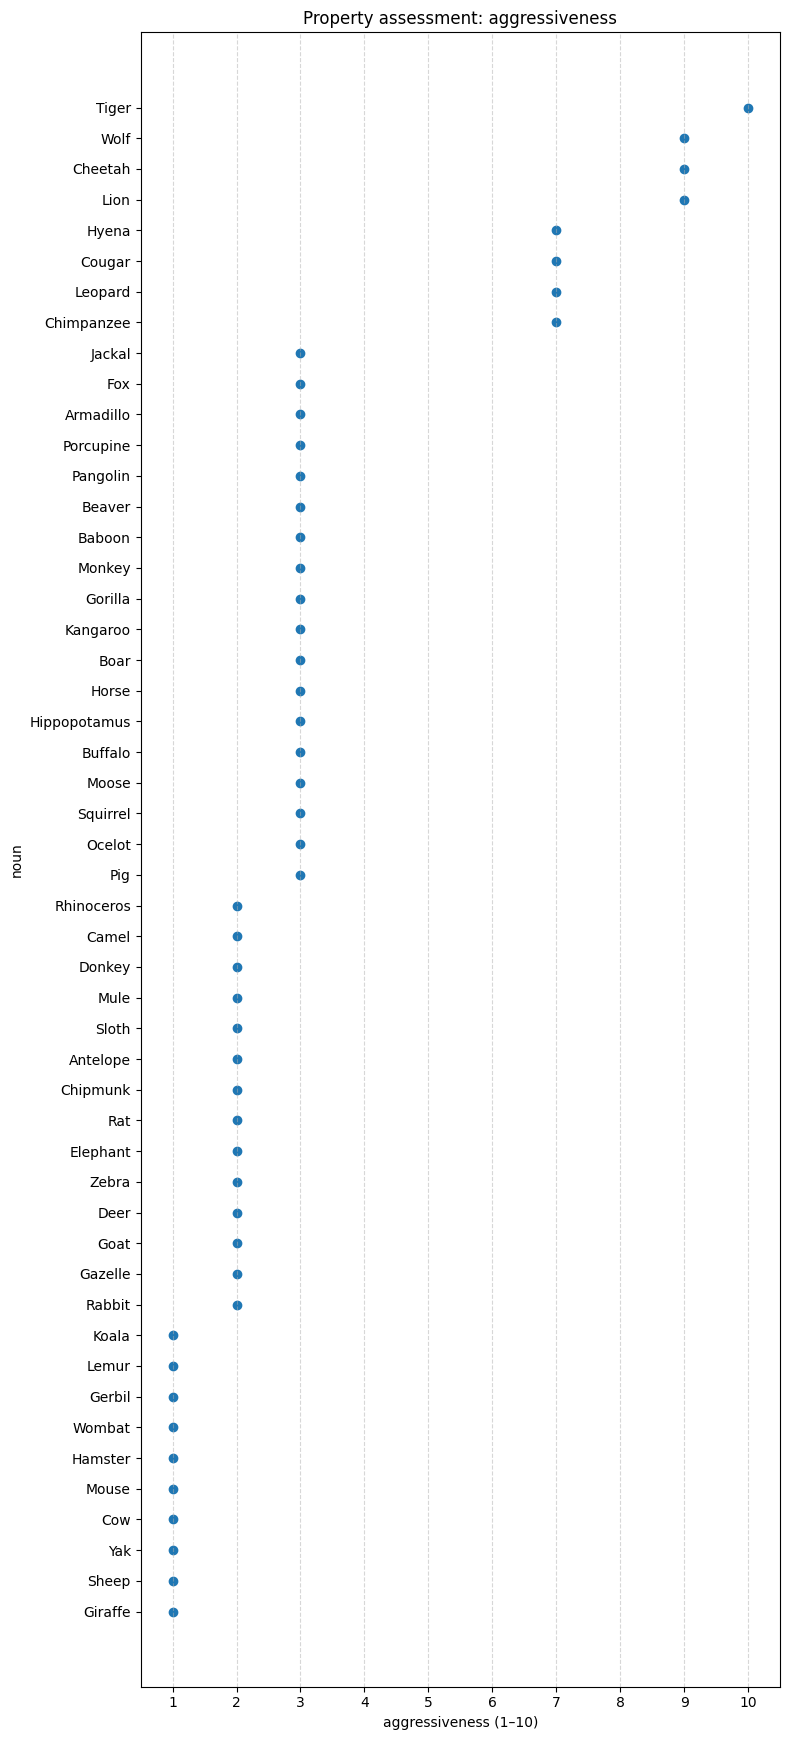

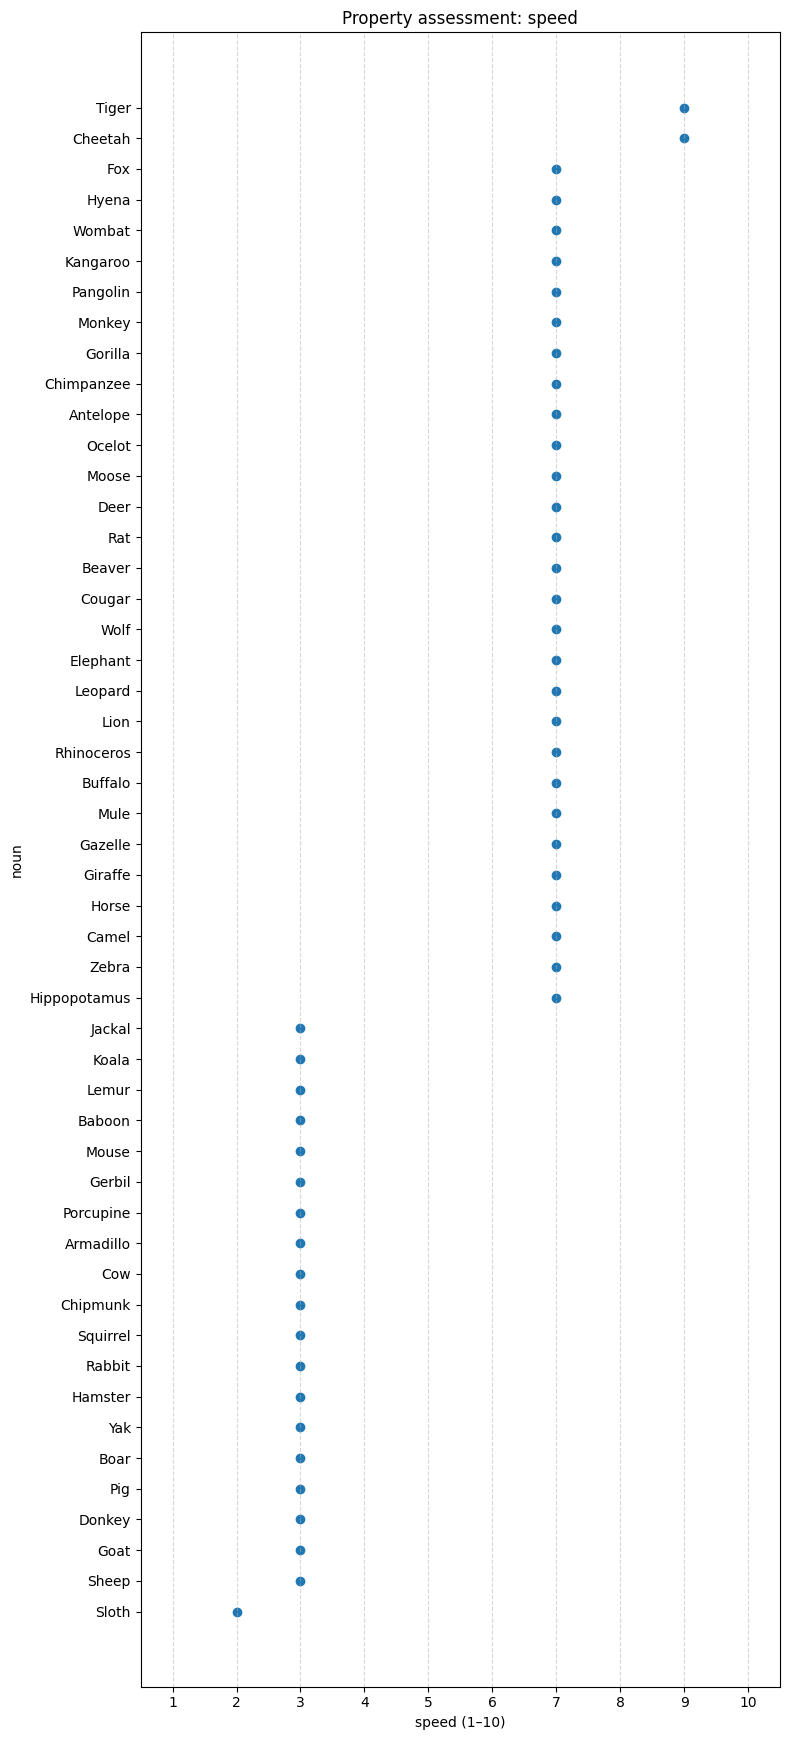

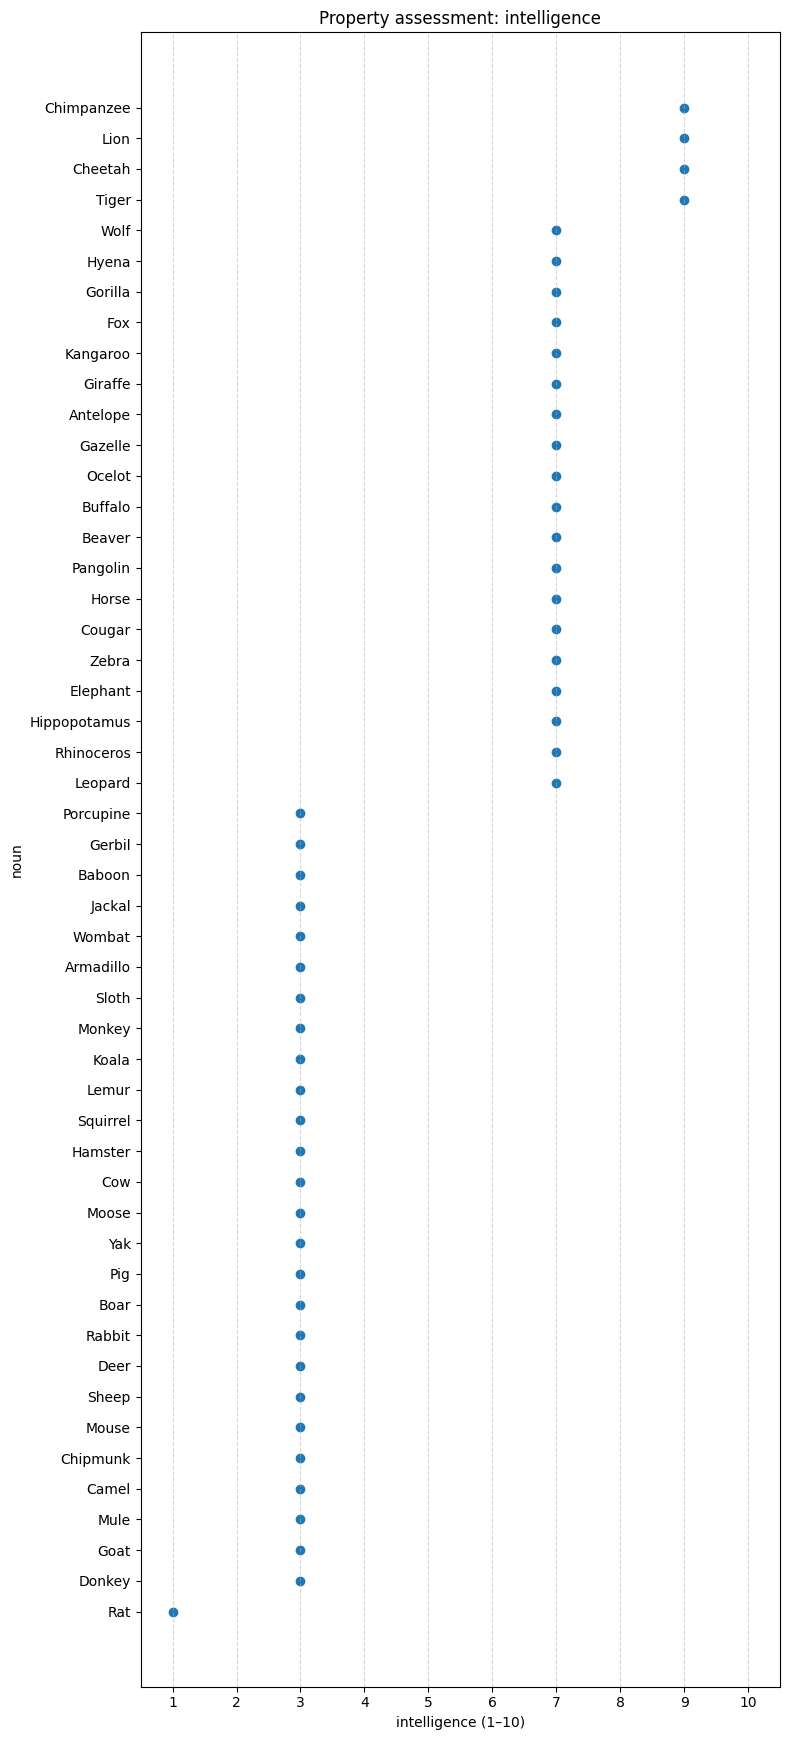

In [6]:
import re, math
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL = "microsoft/Phi-3-mini-4k-instruct"

#Load nouns
with open(nouns_path, "r", encoding="utf-8") as f:
    nouns = [ln.strip() for ln in f if ln.strip()]

#Load prompts
prompts = []
with jsonlines.open(jsonl_path, "r") as reader:
    for obj in reader:
        prompts.append(obj)

# Load model
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL, device_map="auto", dtype="auto")

int_pat = re.compile(r"\b([1-9]|10)\b")

def extract_score(text: str):
    text = (text or "").strip()
    m = int_pat.fullmatch(text) or int_pat.search(text)
    if not m:
        return None
    try:
        val = int(m.group(1))
        return val if 1 <= val <= 10 else None
    except:
        return None

results = []
for noun in nouns:
    for p in prompts:
        full_prompt = p["pre-prompt"] + noun
        messages = [
            {"role": "system", "content": "You MUST output ONLY a single integer between 1 and 10. No words."},
            {"role": "user", "content": full_prompt},
        ]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        enc = tokenizer(text, return_tensors="pt").to(model.device)
        out = model.generate(
            **enc,
            max_new_tokens=5,
            temperature=0.0,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
        gen = out[:, enc["input_ids"].shape[1]:]
        resp = tokenizer.decode(gen[0], skip_special_tokens=True).strip()
        score = extract_score(resp)

        rec = {
            "noun": noun,
            "property": p["property"],
            "prompt": full_prompt,
            "response": resp,
            "score": score,
        }
        print(rec)
        results.append(rec)

#Convert to dataframe
import pandas as pd
import numpy as np

df = pd.DataFrame(results)

total = len(df)
invalid = df["score"].isna().sum()
print(f"Invalid / non-numeric (should be 1–10): {invalid} / {total} ({invalid/total:.1%})")

bad_rows = df[df["score"].isna()][["noun","property","response"]]
display(bad_rows.head(20))

#Clean Data
df_base_clean = df.dropna(subset=["score"]).copy()
df_base_clean["score"] = df_base_clean["score"].astype(int)

df_base_clean.head()

import matplotlib.pyplot as plt

properties = list(df_base_clean["property"].unique())

#Create one graph per property
for prop in properties:
    sub = df_base_clean[df_base_clean["property"] == prop].copy()
    sub = sub.sort_values("score", ascending=True)

    plt.figure(figsize=(8, 0.35*max(6, len(sub))))
    plt.scatter(sub["score"], sub["noun"])
    plt.xlabel(f"{prop} (1–10)")
    plt.ylabel("noun")
    plt.xlim(0.5, 10.5)
    plt.xticks(range(1, 11))
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.title(f"Property assessment: {prop}")
    plt.show()

Reflections on Baseline Prompts:

Overall, I feel the baseline prompts were mediocre in their performance. The best performing estimation was with the weight property. The worst performing estimations were with the aggressiveness and intelligence properties.

Property: Weight

In my opinion, this property was one of the better performing prompts. It seems to have grasped the concept of looking at the noun and identifying what the noun should weigh then classifying the noun into categories. However, some of the weight ranges seem to be very wide. For example, the animals that are rated a seven range from 150 pounds up to 2200 pounds.

Property: Height

This property was not one which the model performed well with. It scored an elephant as being taller than a giraffe. Here again, we see wide ranges of heights. For example, the buffalo is rated the same as a cheetah. It also ranked a rabbit the same as a cow.

Property: Aggressiveness

This property is one of the mediocre performers. This could be due to the nature of the characteristics having a wide range of interpretations. For example, higher ranked animals are predators while some of the lower ranked animals are extremely territorial. Overall, this characteristic would need to be defined better for it to perform better.

Property: Speed

This property was one of the worst performing of the prompts. While it ranked the cheetah and tiger highly, the model also ranked the rhinoceros and hippopotamus highly too. Some of the lower ranked animals are extremely fast for their size, such as the mouse and hamster.

Property: Intelligence

This characteristic was also one of the worst performing prompts. However, the prompt would need to be clarified to get better results. It ranked rats as being one of the least intelligent animals.


Load Improved Prompts and Evaluate Nouns

{'pre-prompt': 'Output Only 1-10. Where 1 is not heavy at all and 10 is extremely heavy. How heavy would you rate this noun when compared to other animals: ', 'property': 'weight'}
{'pre-prompt': 'Output Only 1-10. Where 1 is not tall at all and 10 is extremely tall. How tall would you rate this noun when compared to other animals: ', 'property': 'height'}
{'pre-prompt': 'Output Only 1-10. Where 1 is not territorial and 10 is extremely territorial. How agressive would you rate this noun  when compared to other animals: ', 'property': 'aggressiveness'}
{'pre-prompt': 'Output Only 1-10. Where 1 is slow and 10 is extremely fast. How fast would you rate this noun when compared to other animals: ', 'property': 'speed'}
{'pre-prompt': 'Output Only 1-10. Where 1 is not intelligent at all and 10 is extremely intelligent. How intelligent would you rate this noun  when compared to other animals: ', 'property': 'intelligence'}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'noun': 'Elephant', 'property': 'weight', 'prompt': 'Output Only 1-10. Where 1 is not heavy at all and 10 is extremely heavy. How heavy would you rate this noun when compared to other animals: Elephant', 'response': '10', 'score': 10}
{'noun': 'Elephant', 'property': 'height', 'prompt': 'Output Only 1-10. Where 1 is not tall at all and 10 is extremely tall. How tall would you rate this noun when compared to other animals: Elephant', 'response': '10', 'score': 10}
{'noun': 'Elephant', 'property': 'aggressiveness', 'prompt': 'Output Only 1-10. Where 1 is not territorial and 10 is extremely territorial. How agressive would you rate this noun  when compared to other animals: Elephant', 'response': '2', 'score': 2}
{'noun': 'Elephant', 'property': 'speed', 'prompt': 'Output Only 1-10. Where 1 is slow and 10 is extremely fast. How fast would you rate this noun when compared to other animals: Elephant', 'response': '2', 'score': 2}
{'noun': 'Elephant', 'property': 'intelligence', 'prompt': '

,noun,property,response


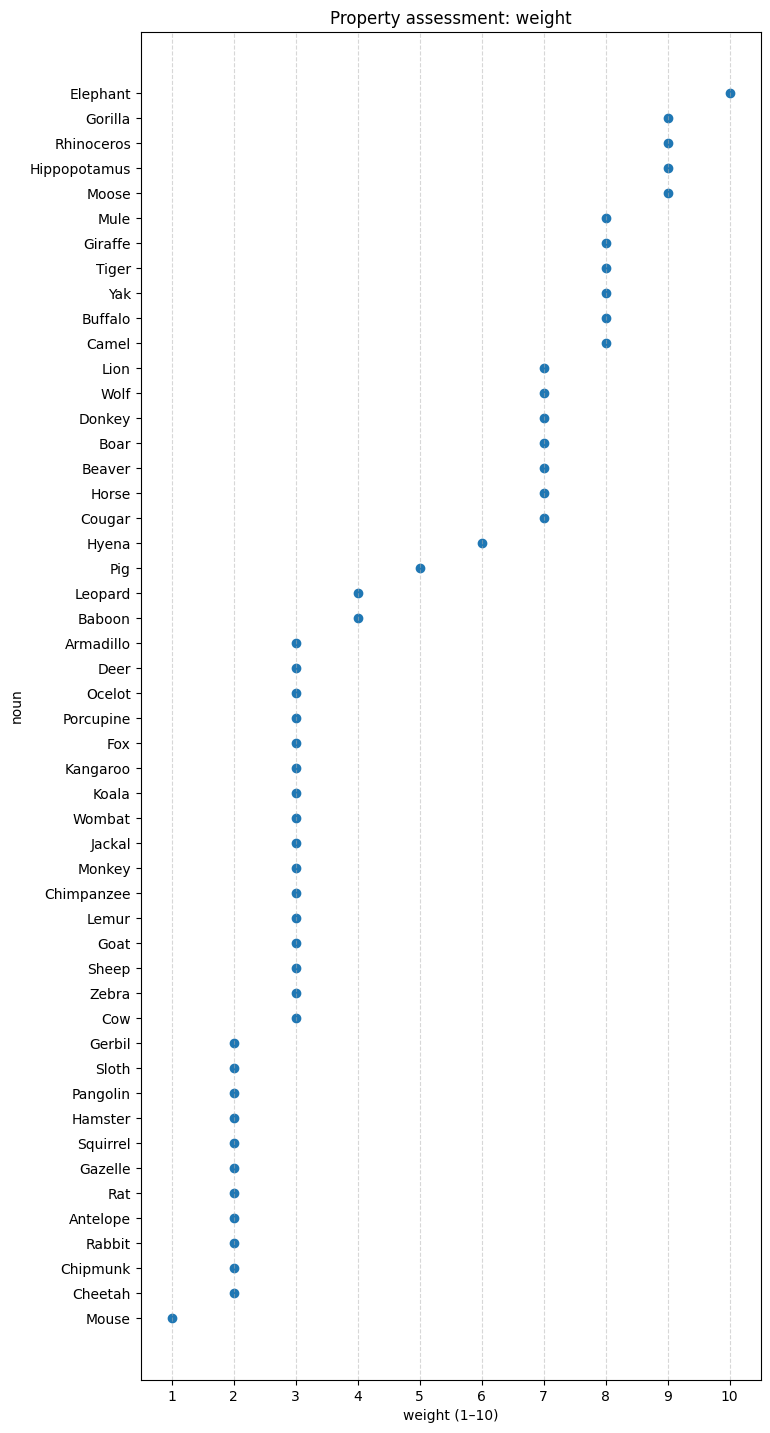

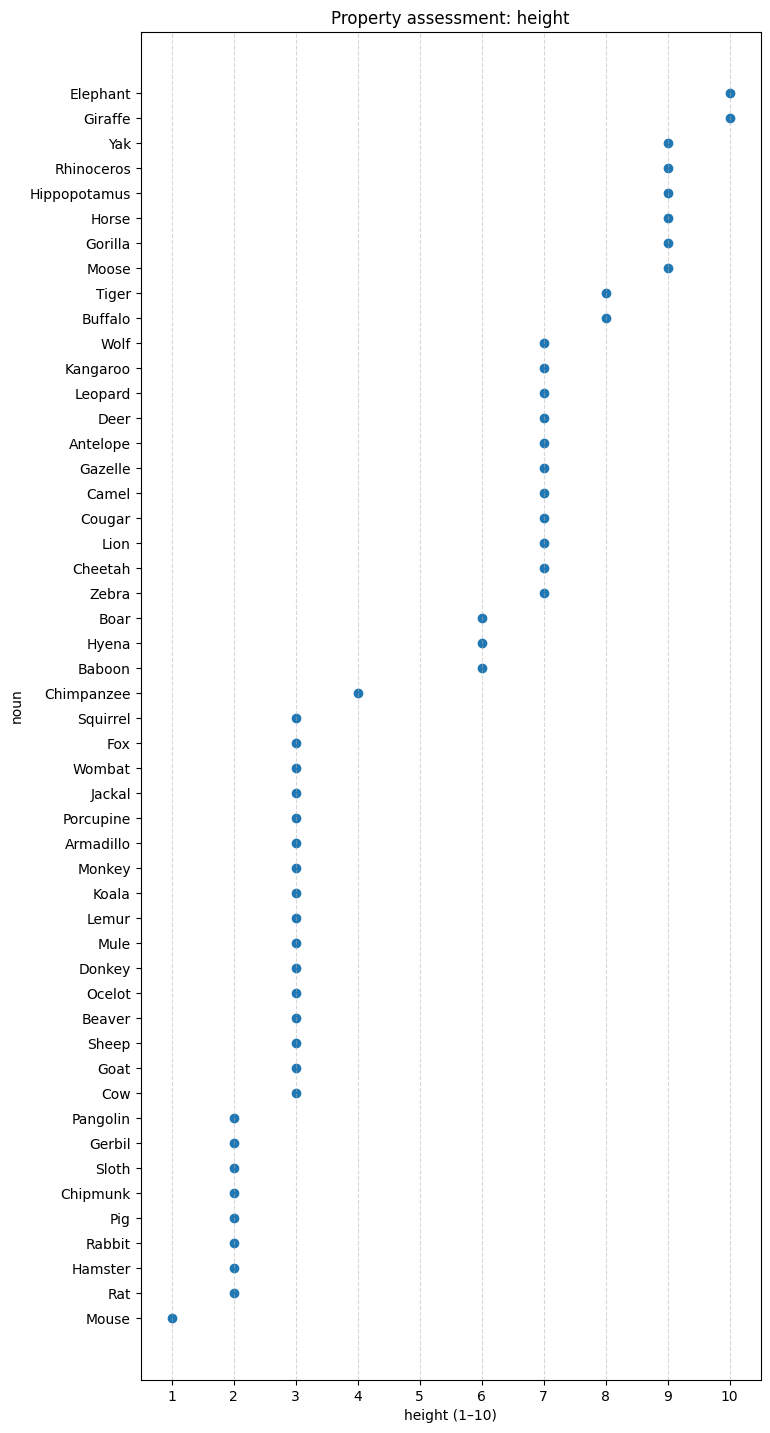

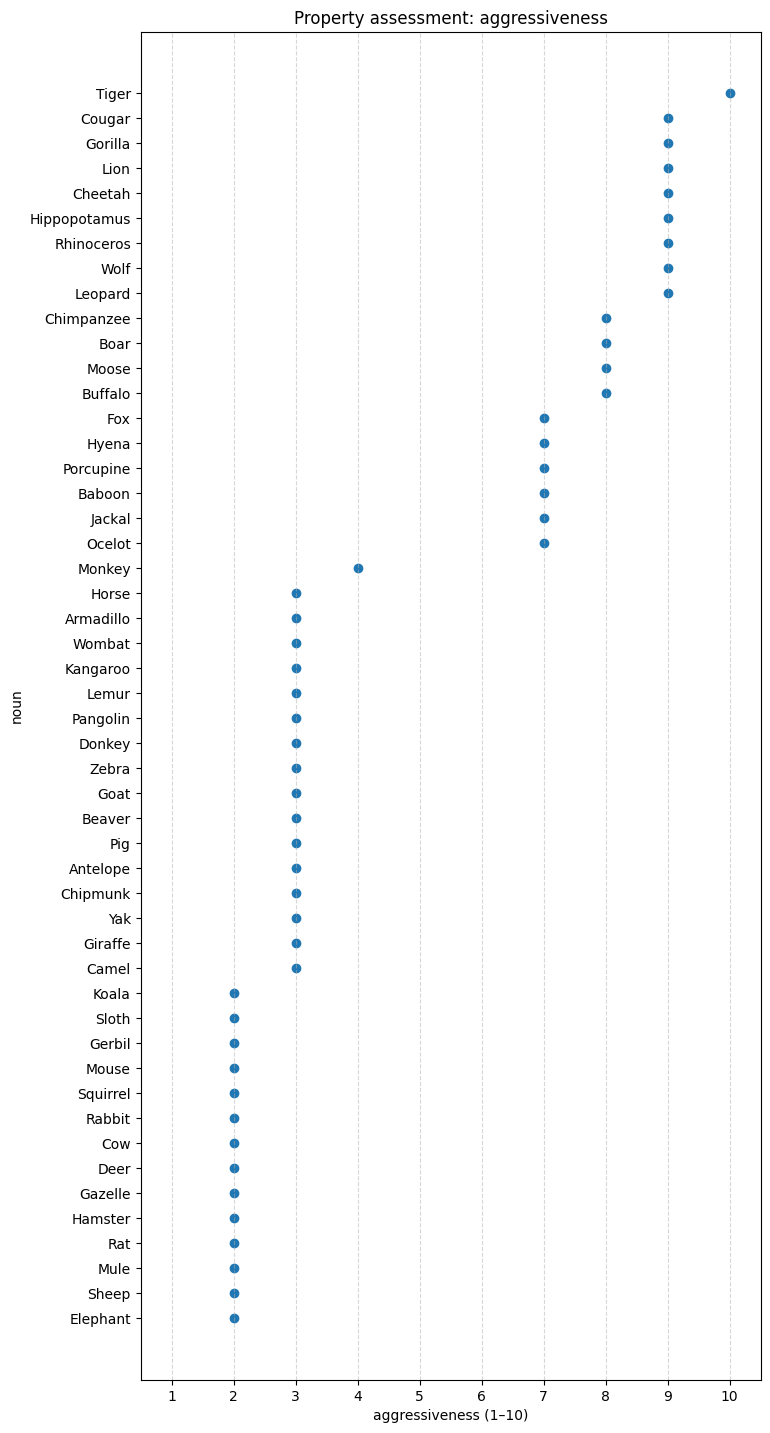

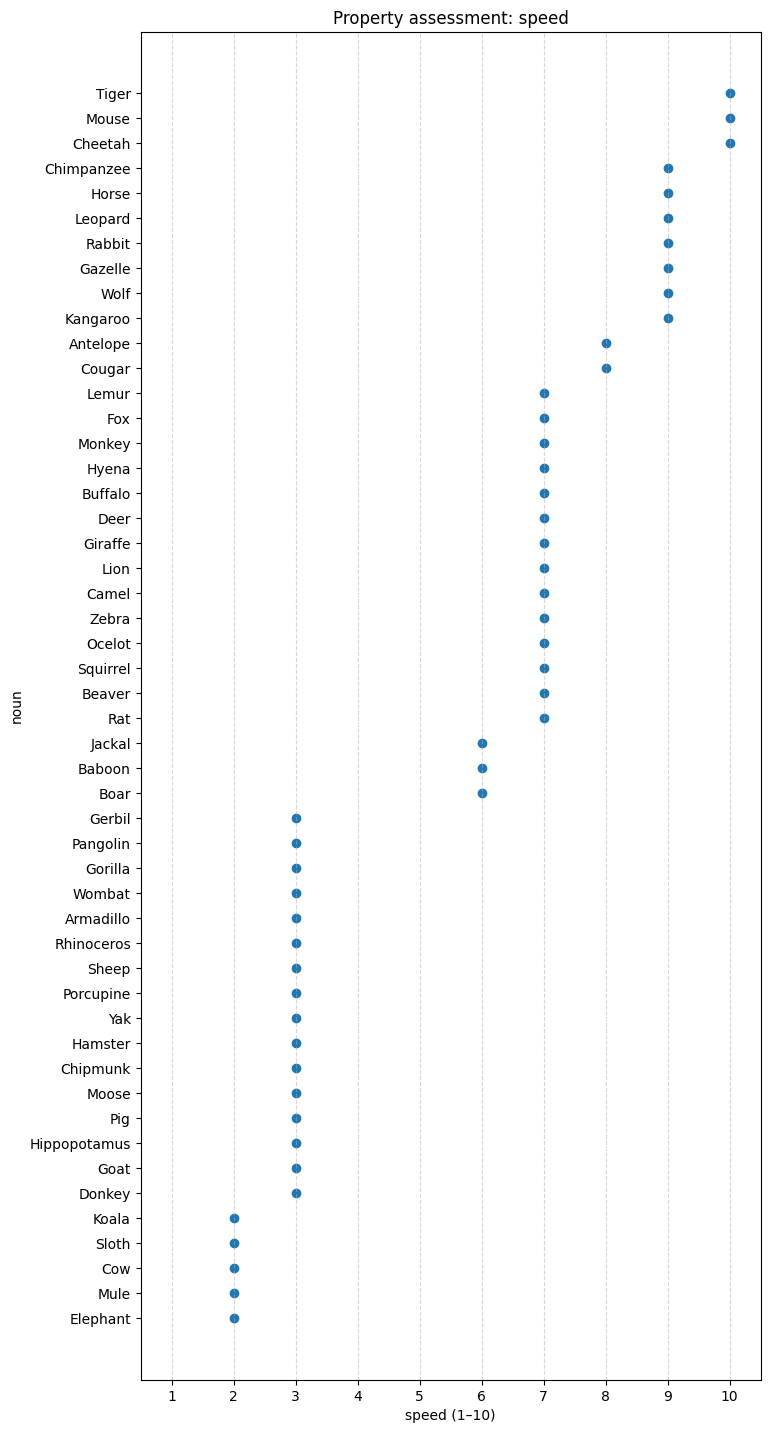

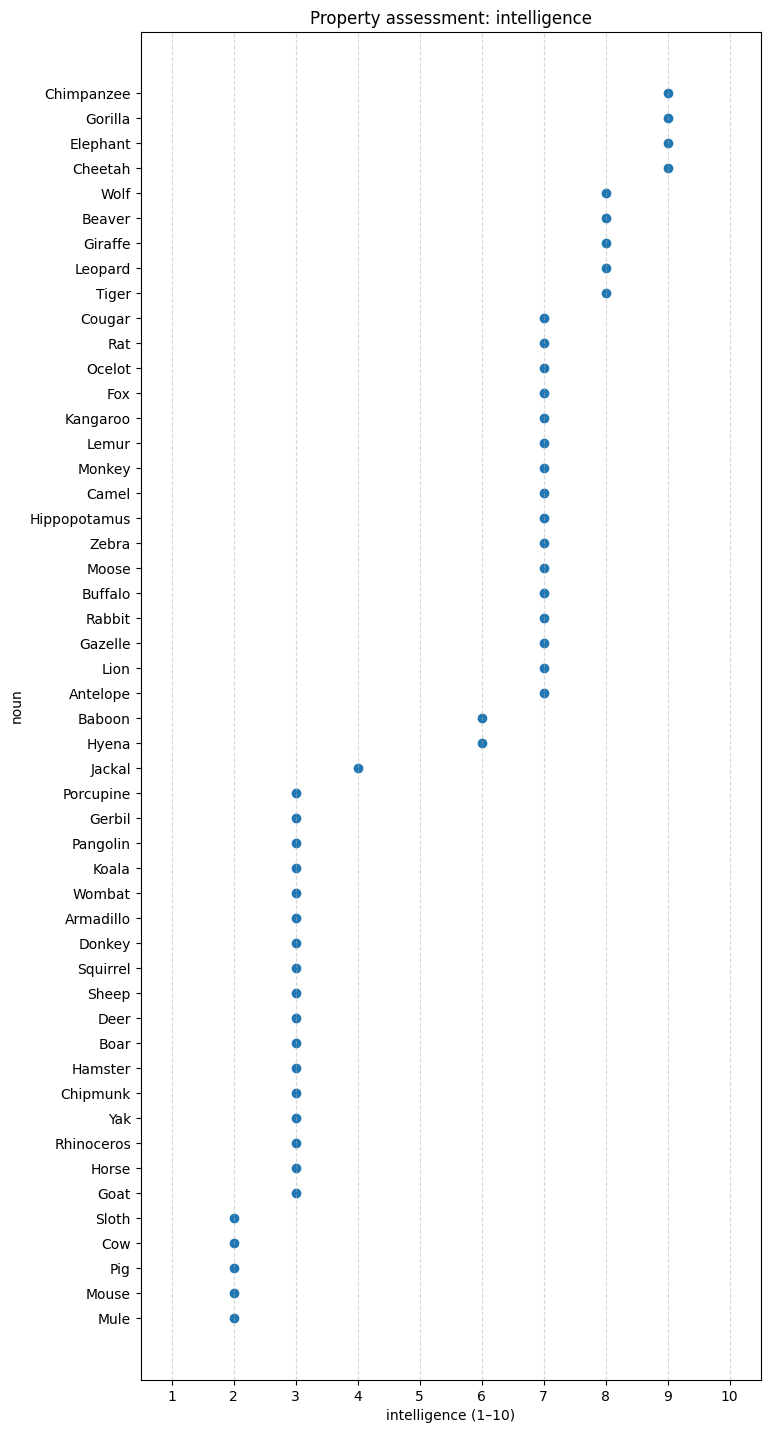

In [11]:
improved_path = NOTEBOOK_DIR / "improved-prompts.jsonl"

with jsonlines.open(improved_path, "r") as reader:
    for obj in reader:
        print(obj)

import re, math
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL = "microsoft/Phi-3-mini-4k-instruct"

#Load nouns
with open(nouns_path, "r", encoding="utf-8") as f:
    nouns = [ln.strip() for ln in f if ln.strip()]

#Load prompts
prompts = []
with jsonlines.open(improved_path, "r") as reader:
    for obj in reader:
        prompts.append(obj)

#Load model
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL, device_map="auto", dtype="auto")

int_pat = re.compile(r"\b([1-9]|10)\b")

def extract_score(text: str):
    text = (text or "").strip()
    m = int_pat.fullmatch(text) or int_pat.search(text)
    if not m:
        return None
    try:
        val = int(m.group(1))
        return val if 1 <= val <= 10 else None
    except:
        return None

results = []
for noun in nouns:
    for p in prompts:
        full_prompt = p["pre-prompt"] + noun
        messages = [
            {"role": "system", "content": "You MUST output ONLY a single integer between 1 and 10. No words."},
            {"role": "user", "content": full_prompt},
        ]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        enc = tokenizer(text, return_tensors="pt").to(model.device)
        out = model.generate(
            **enc,
            max_new_tokens=5,
            temperature=0.0,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
        gen = out[:, enc["input_ids"].shape[1]:]
        resp = tokenizer.decode(gen[0], skip_special_tokens=True).strip()
        score = extract_score(resp)

        rec = {
            "noun": noun,
            "property": p["property"],
            "prompt": full_prompt,
            "response": resp,
            "score": score,
        }
        print(rec)
        results.append(rec)

#Convert to dataframes
import pandas as pd

df = pd.DataFrame(results)

total = len(df)
invalid = df["score"].isna().sum()
print(f"Invalid / non-numeric (should be 1–10): {invalid} / {total} ({invalid/total:.1%})")

#clean data
bad_rows = df[df["score"].isna()][["noun","property","response"]]
display(bad_rows.head(20))

df_imp_clean = df.dropna(subset=["score"]).copy()
df_imp_clean["score"] = df_imp_clean["score"].astype(int)

df_imp_clean.head()

#Create one graph per property
import matplotlib.pyplot as plt

properties = list(df_imp_clean["property"].unique())

for prop in properties:
    sub = df_imp_clean[df_imp_clean["property"] == prop].copy()
    sub = sub.sort_values("score", ascending=True)

    plt.figure(figsize=(8, 0.35*max(6, len(sub))))
    plt.scatter(sub["score"], sub["noun"])
    plt.xlabel(f"{prop} (1–10)")
    plt.ylabel("noun")
    plt.xlim(0.5, 10.5)
    plt.xticks(range(1, 11))
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.title(f"Property assessment: {prop}")
    plt.show()


Graphs for Baseline and Improved Prompts

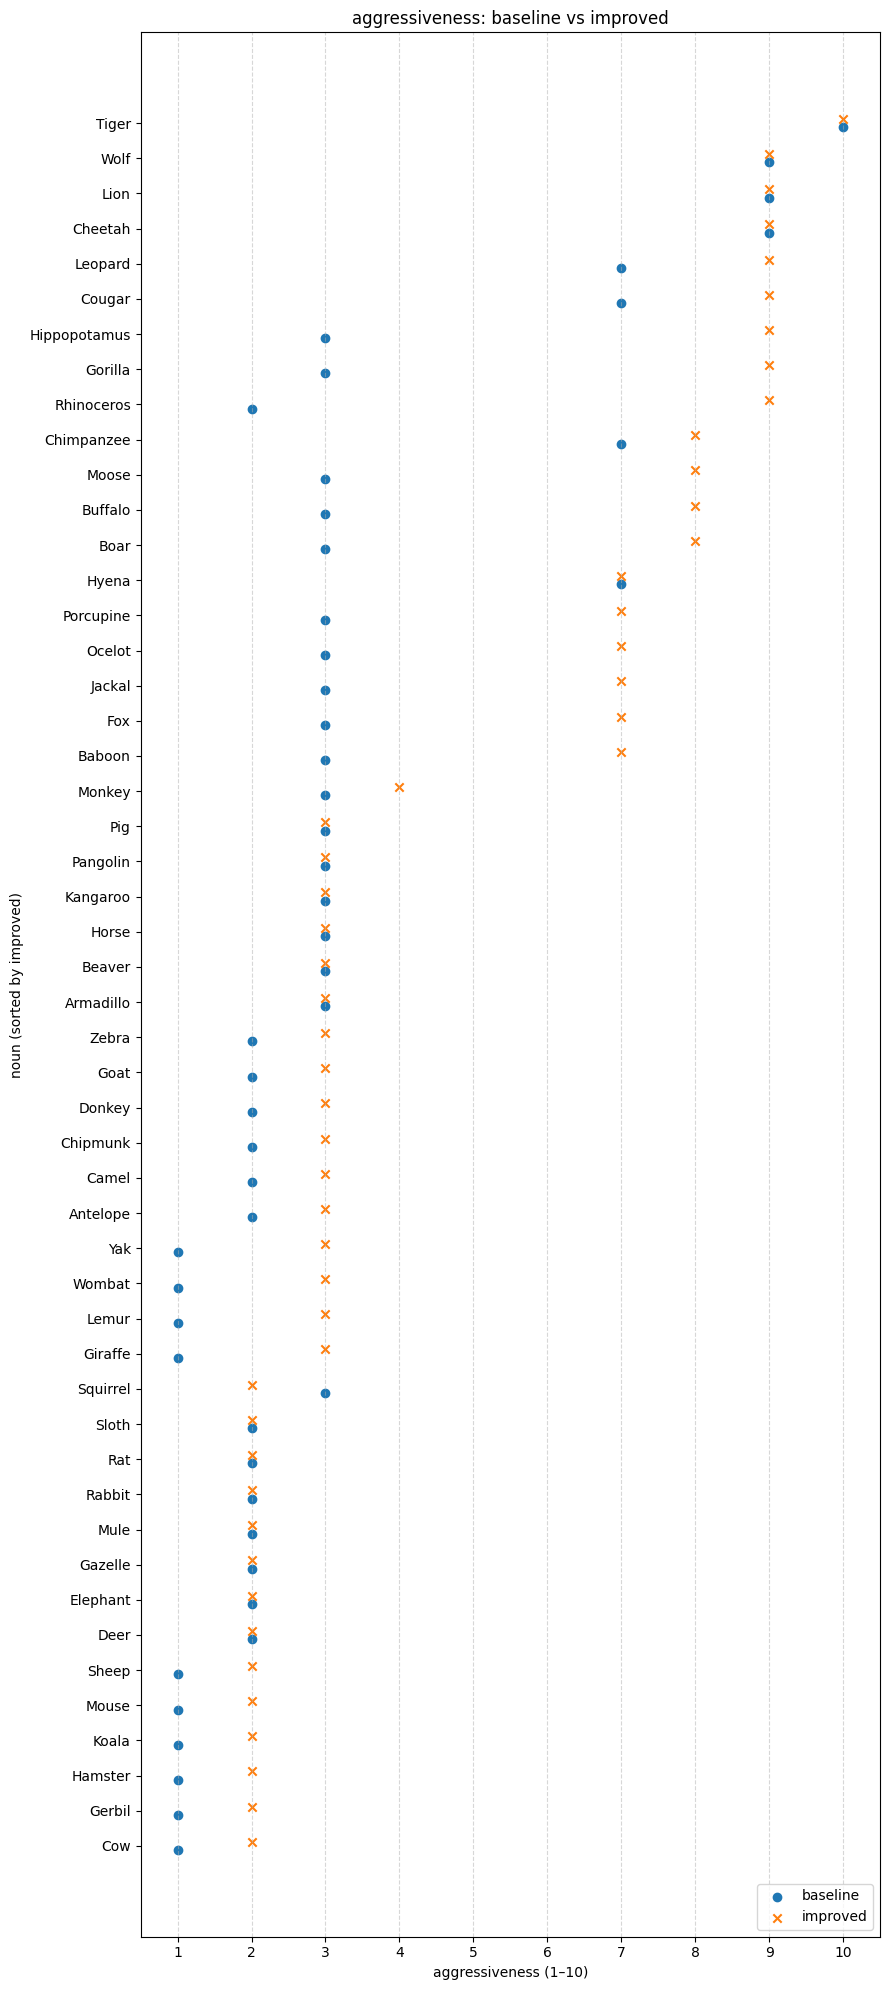

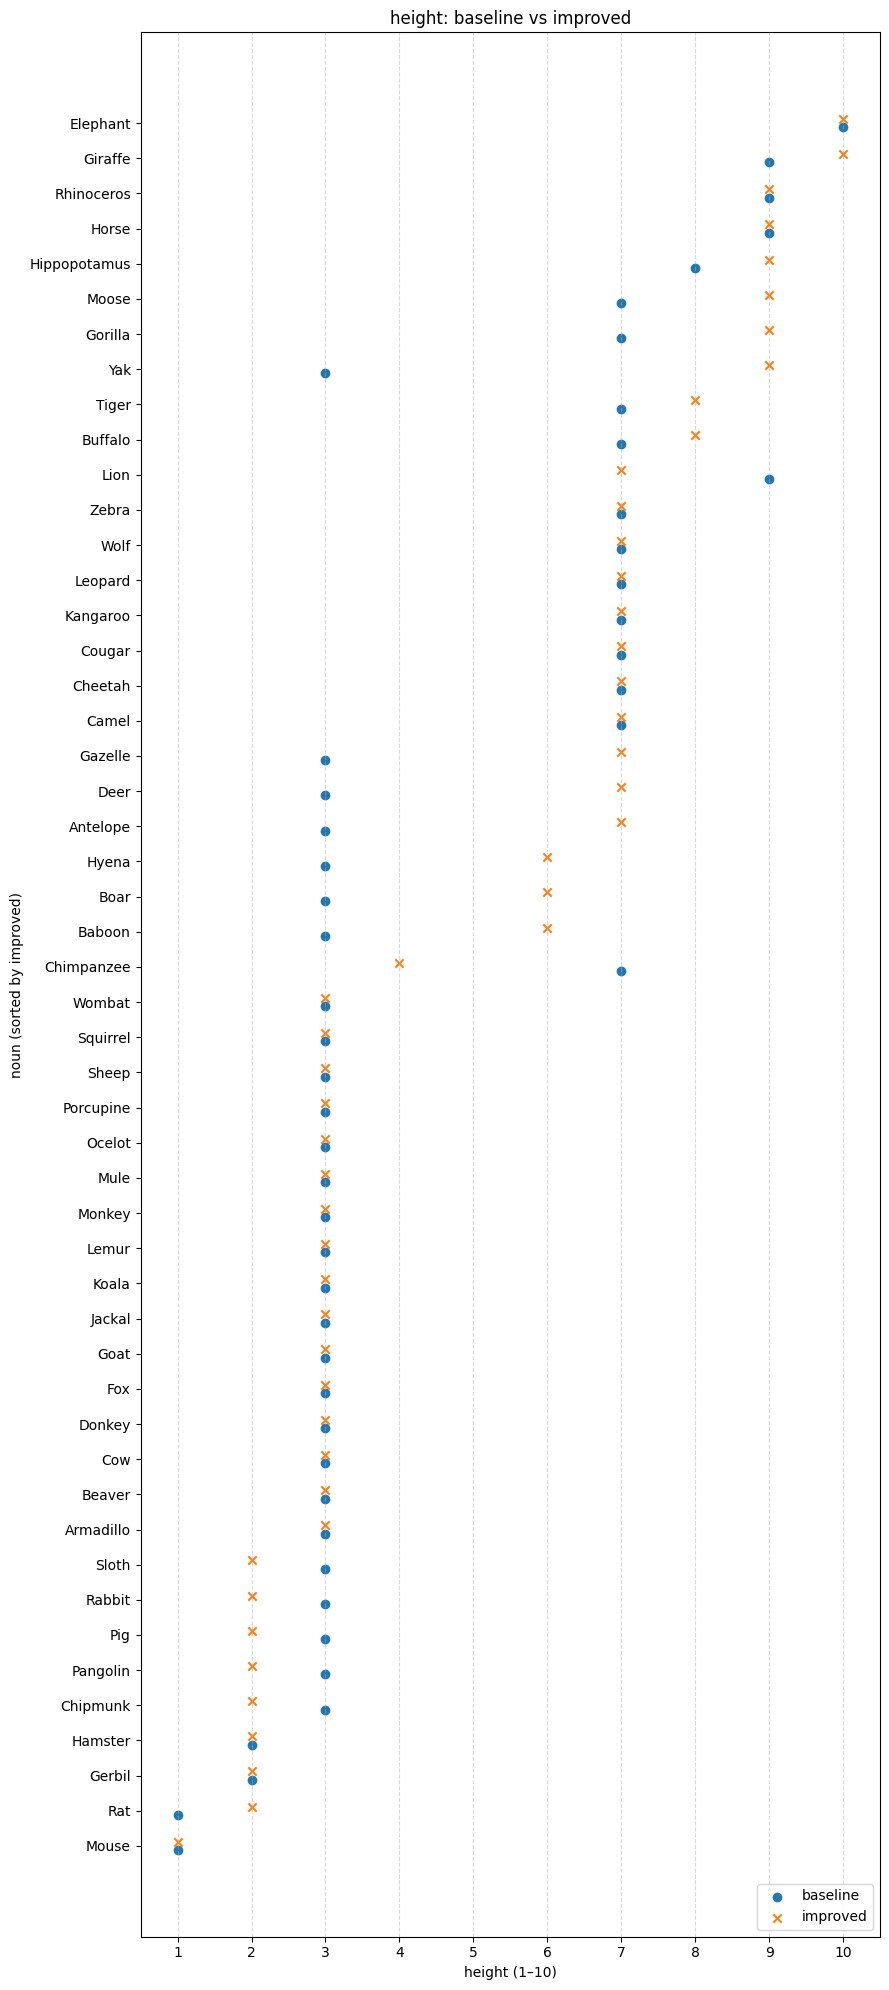

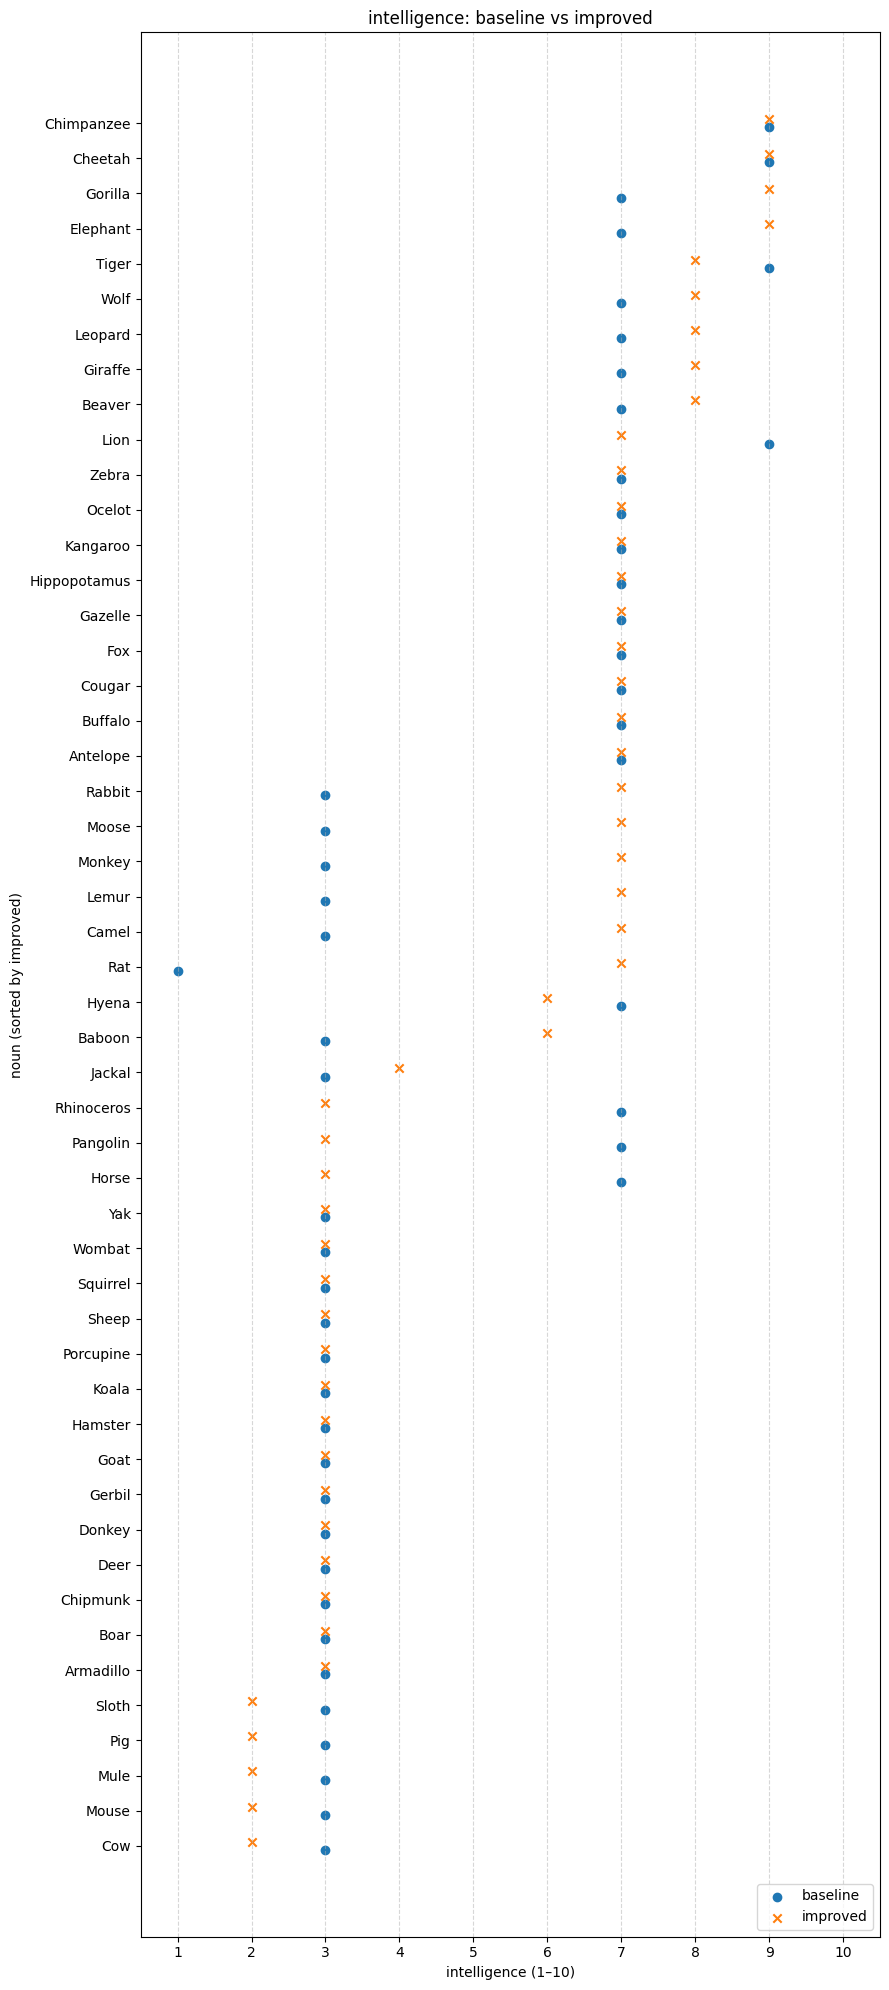

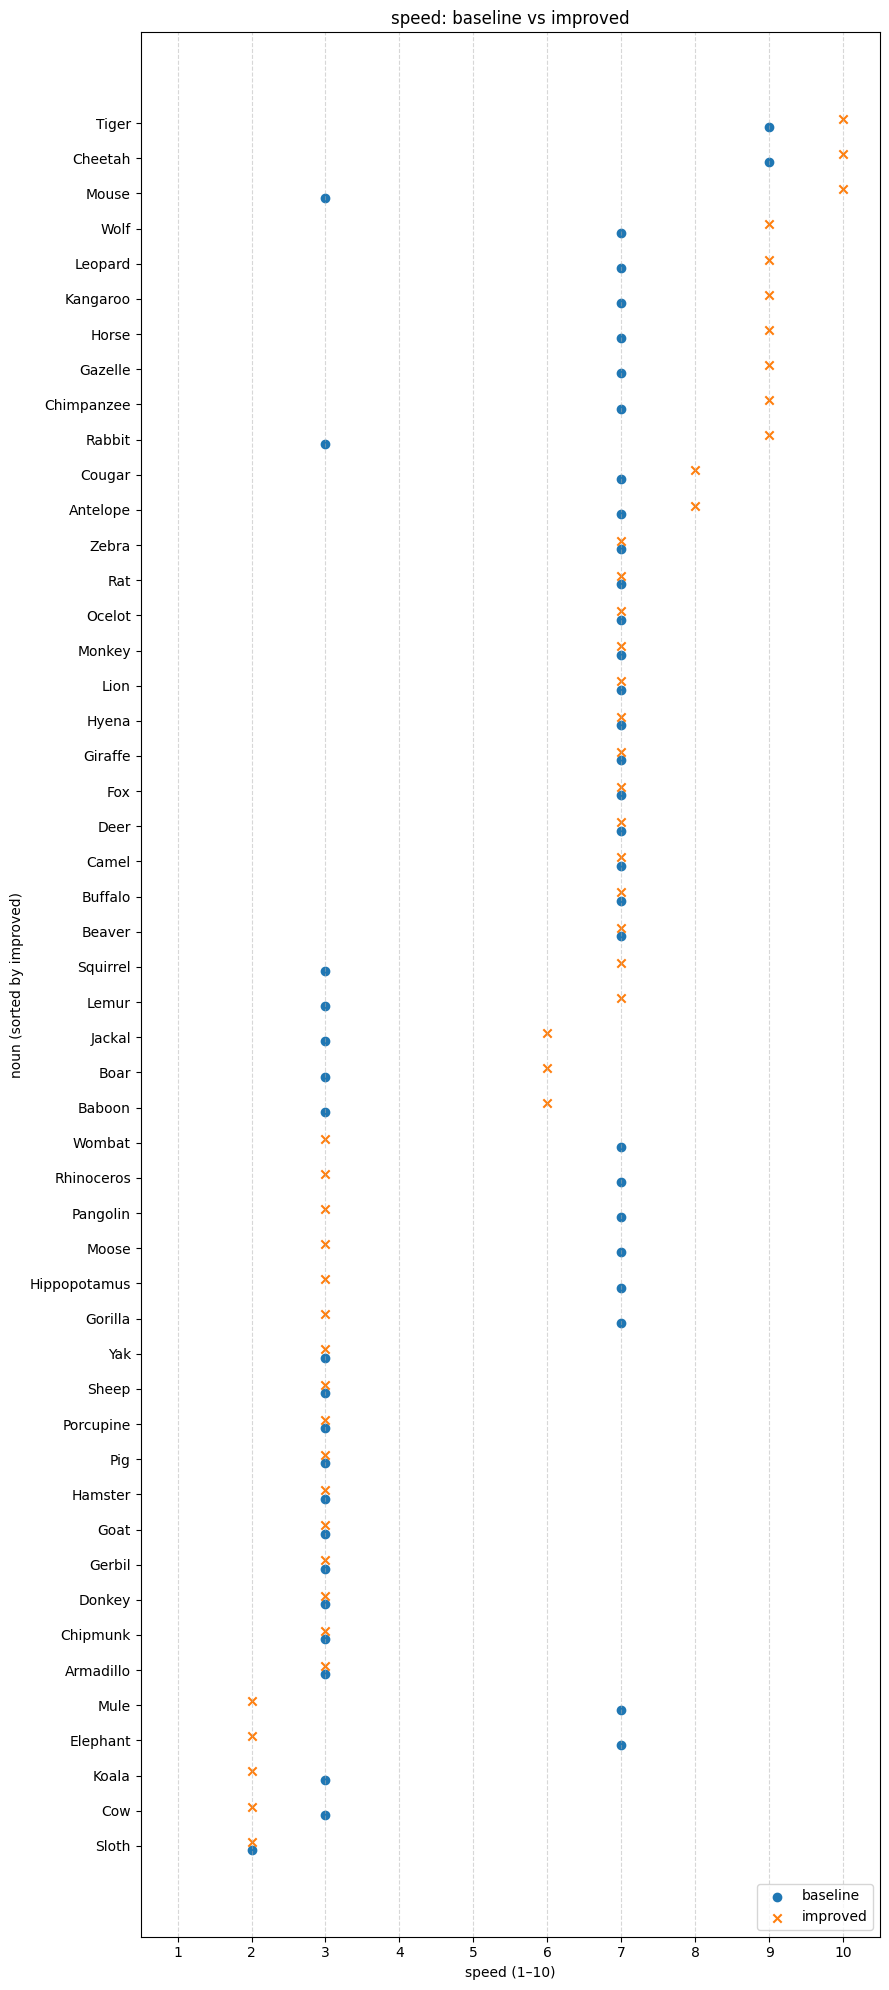

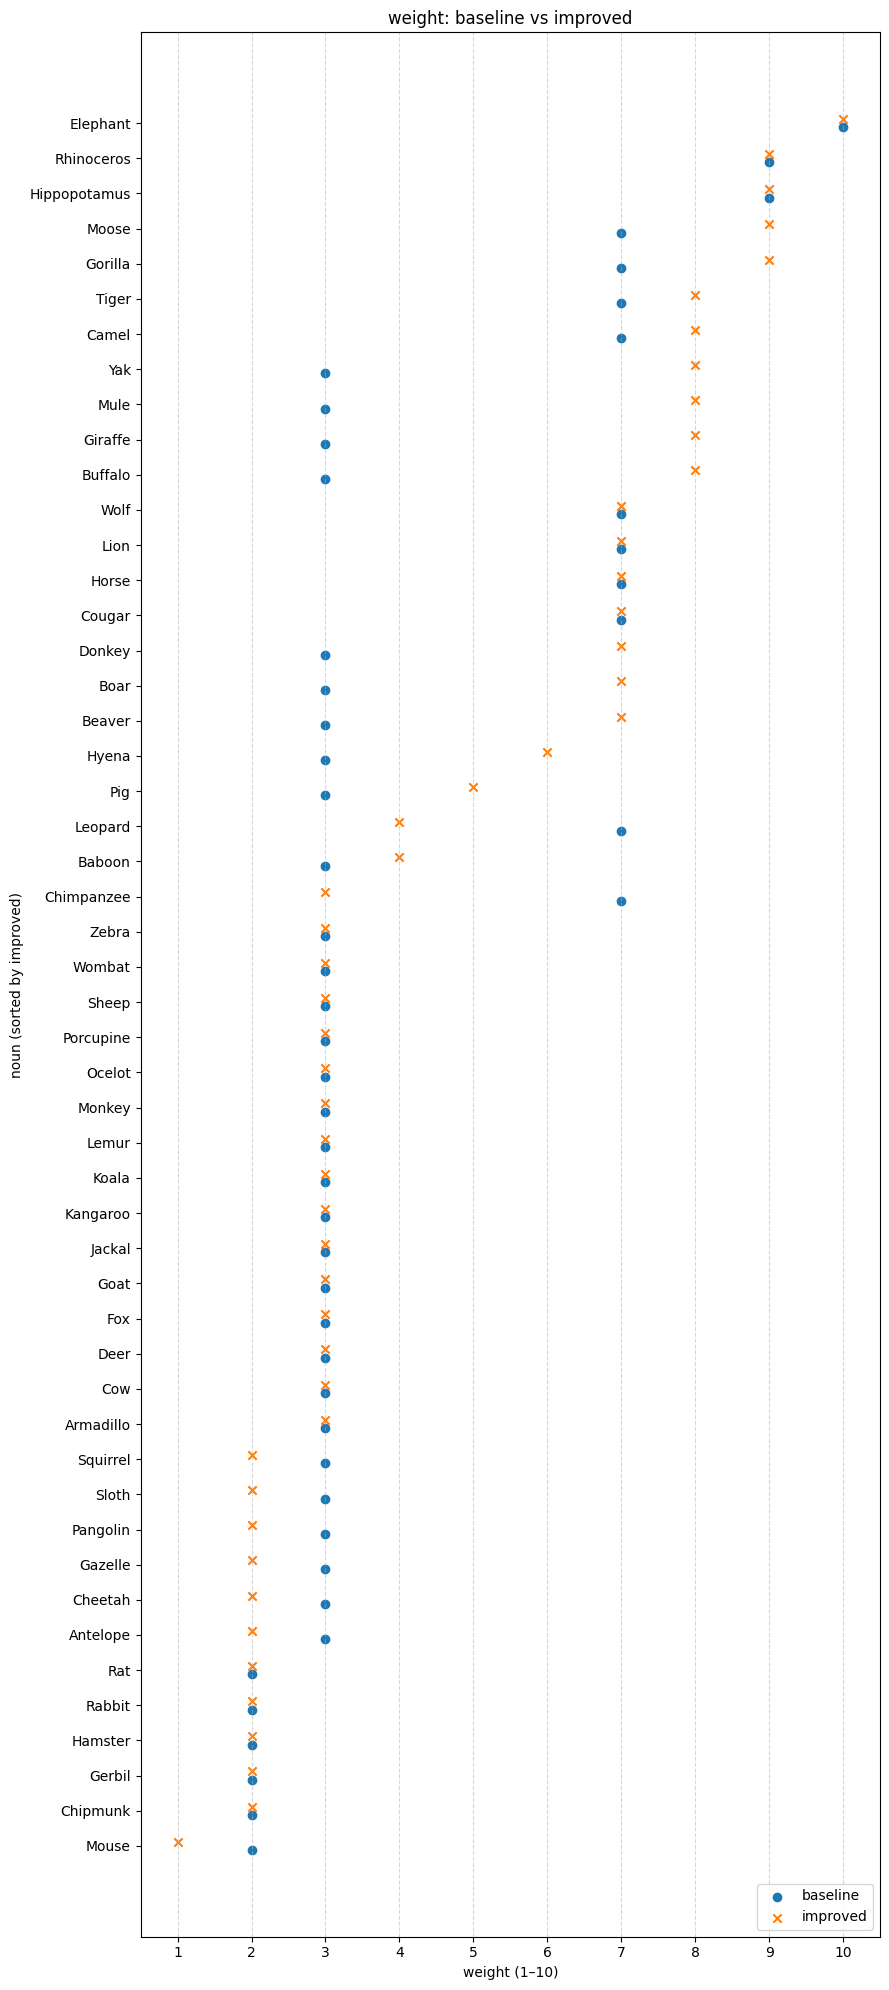

In [12]:
for df_ in (df_base_clean, df_imp_clean):
    df_["score"] = pd.to_numeric(df_["score"], errors="coerce").astype("Int64")

merged = (
    df_base_clean.rename(columns={"score": "baseline"})
    .merge(
        df_imp_clean.rename(columns={"score": "improved"}),
        on=["noun","property"], how="outer"
    )
)

mv = merged.dropna(subset=["improved"]).copy()
mv["baseline"] = mv["baseline"].astype("Int64")
mv["improved"] = mv["improved"].astype(int)

PROPERTIES = mv["property"].dropna().unique().tolist()

for prop in PROPERTIES:
    sub = mv[mv["property"] == prop].copy()

    sub = sub.sort_values(["improved", "baseline", "noun"], ascending=[True, True, True]).reset_index(drop=True)

    y_labels = sub["noun"].tolist()
    y = np.arange(len(y_labels))

    xb = sub["baseline"].astype("float").to_numpy()
    xi = sub["improved"].astype("float").to_numpy()

    mask_b = ~np.isnan(xb)
    mask_i = ~np.isnan(xi)

    plt.figure(figsize=(9, max(4, 0.4*len(y_labels))))

    jitter = 0.12
    plt.scatter(xb[mask_b], y[mask_b] - jitter, label="baseline", marker="o")
    plt.scatter(xi[mask_i], y[mask_i] + jitter, label="improved", marker="x")

    plt.yticks(y, y_labels)
    plt.xlabel(f"{prop} (1–10)")
    plt.ylabel("noun (sorted by improved)")
    plt.xlim(0.5, 10.5)
    plt.xticks(range(1, 11))
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.title(f"{prop}: baseline vs improved")
    plt.legend(loc="lower right")
    plt.show()

Reflections on Improved Prompts.

Property: Weight

Weight has seen improvement in the responses. Animals like squirrels and sloth are no longer in the same rank as a cow or goat.

Property: Height

There is an improvement from the baseline in this property. For example, the hippopotamus and yak are now in the same ranking as a horse. The alignment between nouns is better matched.

Property: Aggressiveness

The model improved significantly after making changes to the prompt. By defining aggressiveness as being territorial and giving the model more details on the scale, it was able to rate the nouns better. For instance, the hippopotamus was a baseline of 3, but with the improved prompt it is now 9.

Property: Speed

Speed seems to be the property which has made the greatest improvement for the changes made to the prompt. The mouse is not in the top three fastest for the animals. The shift in many of the animals’ rankings seems more in line with what I expected to see.

Property: Intelligence

Intelligence does not seem to have changed much. There are shifts in some of the rankings, but they may not be correct in their interpretation. The prompt was modified in the same way that the prompt for aggressiveness was, but the comparison to other animals may be the difference. It may be better to use humans as a comparison.

Final Reflections

My method for selecting nouns came from what I was doing just prior to starting the assignment. I had been reading a book about animals to my grandson. In my selection of properties, I knew I would need to have them ranked from 1 to 10 so I chose characteristics of animals which could be ranked this way. After running the baseline assessment, I felt like I needed to make the prompts more specific. For example, I had told the LLM that I wanted it to return 1 to 10 for each noun, but what did that mean? The LLM was rating these properties, but what was it using for comparison? By telling the LLM that the scale was 1 to 10 where 1 is the lowest and 10 is the highest when comparing to other animals, it was able to return rating closer to what would be expected. This gave some clarity to what I wanted it to answer.  I believe the model worked well for what it had to work with, but prompts with more information and more defined properties would definitely improve its performance.
